<a href="https://colab.research.google.com/github/sohv/ai_from_scratch/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import dependencies

In [1]:
import torch
import torch.nn as nn
import math

# Define classes

### InputEmbeddings

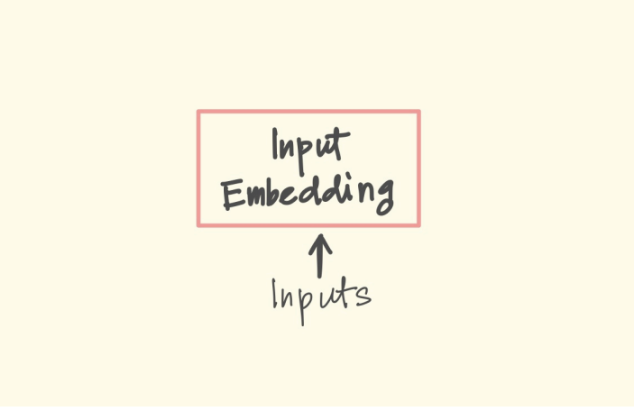

Define a class for embedding input tokens into vectors, inheriting from PyTorch Module class

In [19]:
class InputEmbeddings(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):# model dimension and vocab size as parameters
     super().__init__()
     self.d_model = d_model
     self.vocab_size = vocab_size
     self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x): # forward pass method that processes input x
    return self.embedding(x) * math.sqrt(self.d_model) # applies embedding and multiplies by sqrt (d_model) to keep variance stable

### Positional Encoding Class

add positional information to embeddings.

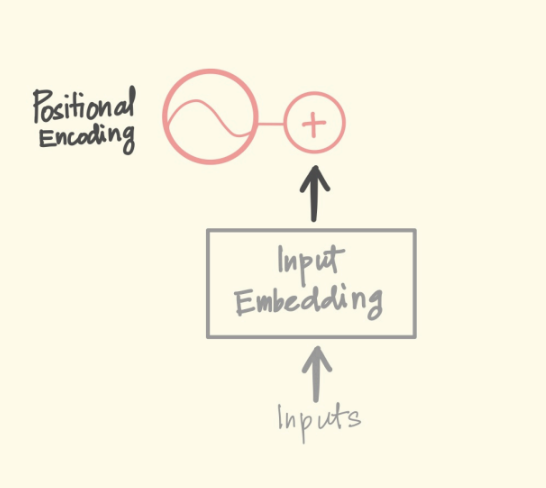

In [20]:
class PositionalEncoding(nn.Module):

  # add constructor that takes model dim, max sequence length and dropout rate as parameters.
  def __init__(self, d_model:int, seq_len:int, dropout:float) -> None:
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout) # creates a dropout layer

    #initialize a tensor for positional encodings with zeros
    pe = torch.zeros(seq_len, d_model)
    # create a column vector with position indices from 0 to seq_len - 1
    position = torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1)
    # create division term for sinusoidal functions per papers formula
    div_term = torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)))
    # apply sine to even indices of the position encoding
    pe[:,0::2] = torch.sin(position*div_term)
    # apply cosine to odd indices of the position encoding
    pe[:,1::2] = torch.cos(position*div_term)
    # adds batch dimension to positional encoding
    pe = pe.unsqueeze(0)
    # register the positional encoding as buffer
    self.register_buffer('pe',pe)

  def forward(self,x): #forward pass for x
    x = x + (self.pe[:,:x.shape[1],:]).requires_grad_(False)
    # pass positional encoding to input, trimmed to match input sequence length, with gradient disabled.
    return self.dropout(x) # applies dropout to the sum of input and positional encoding

### Multi-head attention block

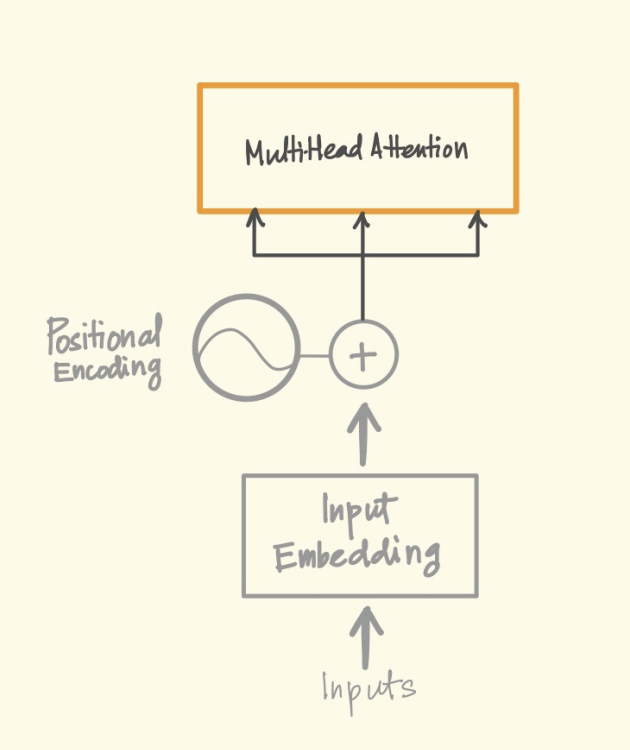

In [21]:
class MultiHeadAttentionBlock(nn.Module):
  def __init__(self,d_model:int,h:int,dropout:float) -> None: # constructor with parameters model dim, number of heads and dropout rate
    super().__init__()
    self.d_model = d_model
    self.h = h

    assert d_model % h == 0, "d_model is not divisible by h" #ensure model dimension is divisible by the number of heads
    self.d_k = d_model // h #dimension per head
    self.w_q = nn.Linear(d_model,d_model,bias=False) # linear projection for query vectors without bias
    self.w_k = nn.Linear(d_model,d_model,bias=False) # linear projection for key vectors without bias
    self.w_v = nn.Linear(d_model,d_model,bias=False) # linear projection for value vectors without bias
    self.w_o = nn.Linear(d_model,d_model,bias=False) # outputs linear projection without bias
    self.dropout = nn.Dropout(dropout) # dropout layer for regularization

  @staticmethod
  def attention(query,key,value,mask,dropout:nn.Dropout): # implement scaled dot product attention
    d_k = query.shape[-1] # dimension of keys/queries
    attention_scores = (query @ key.transpose(-2,-1))/math.sqrt(d_k) # calculate attention score using matrix multiplication and scaling
    if mask is not None:
      attention_scores.masked_fill_(mask==0,-1e9) # applies mask by setting masked positions to negative infinity
    attention_scores = attention_scores.softmax(dim=-1) # applies softmax to get attention probabilities
    if dropout is not None:
      attention_scores = dropout(attention_scores) # applies dropout to attention scores if provided
    return (attention_scores @ value), attention_scores # return weighted values and attention scores

  def forward(self,q,k,v,mask): # forward pass with query, key, value and mask
    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v) # applies linear projection to inputs

    query = query.view(query.shape[0],query.shape[1],self.h,self.d_k).transpose(1,2)
    key = key.view(key.shape[0],key.shape[1],self.h,self.d_k).transpose(1,2)
    value = value.view(value.shape[0],value.shape[1],self.h,self.d_k).transpose(1,2) # Reshapes and transposes the tensors to have shape (batch_size, num_heads, seq_len, head_dim)

    x, self.attention_scores = MultiHeadAttentionBlock.attention(query,key,value,mask,self.dropout) # calls the attention function with the prepared query, key, value, mask and dropout

    x = x.transpose(1,2).contiguous().view(x.shape[0],-1,self.h*self.d_k) # Transposes and reshapes the output of attention back to the original shape (batch_size, seq_len, d_model)

    return self.w_o(x) # Applies the final linear projection to the concatenated output

### Layer Normalization

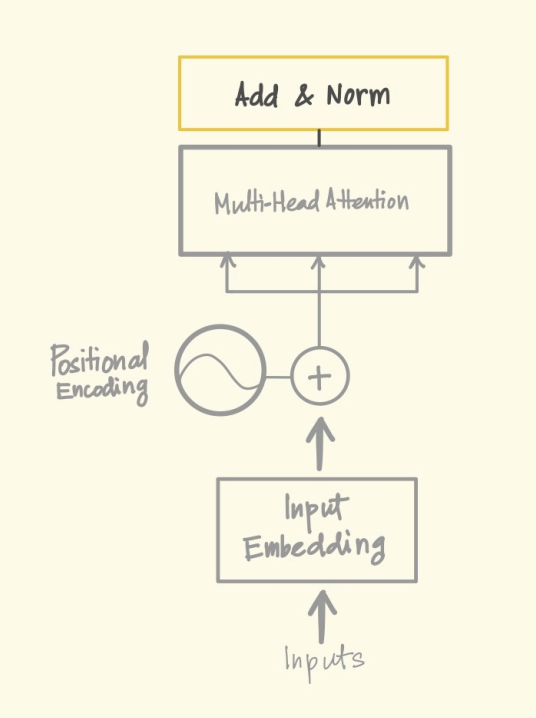

In [22]:
#implement layer normalization for stabilizing network activations
class LayerNormalization(nn.Module):
  def __init__(self,features: int,eps:float=10**-6) -> None: # constructor with feature count and a small epsilon to prevent division by zero
    super().__init__()
    self.eps = eps # store epsilon
    self.alpha = nn.Parameter(torch.ones(features)) # learnable scaling parameter
    self.bias = nn.Parameter(torch.zeros(features)) # learnable bias parameter initialized to zeros

  def forward(self,x):
    mean = x.mean(dim = -1, keepdim = True) # calculate mean across feature dimension
    std = x.std(dim = -1, keepdim = True) # calculate std across feature dimension
    return self.alpha * (x-mean)/(std+self.eps) + self.bias #normalize input, apply scaling and bias

### feed-forward block class
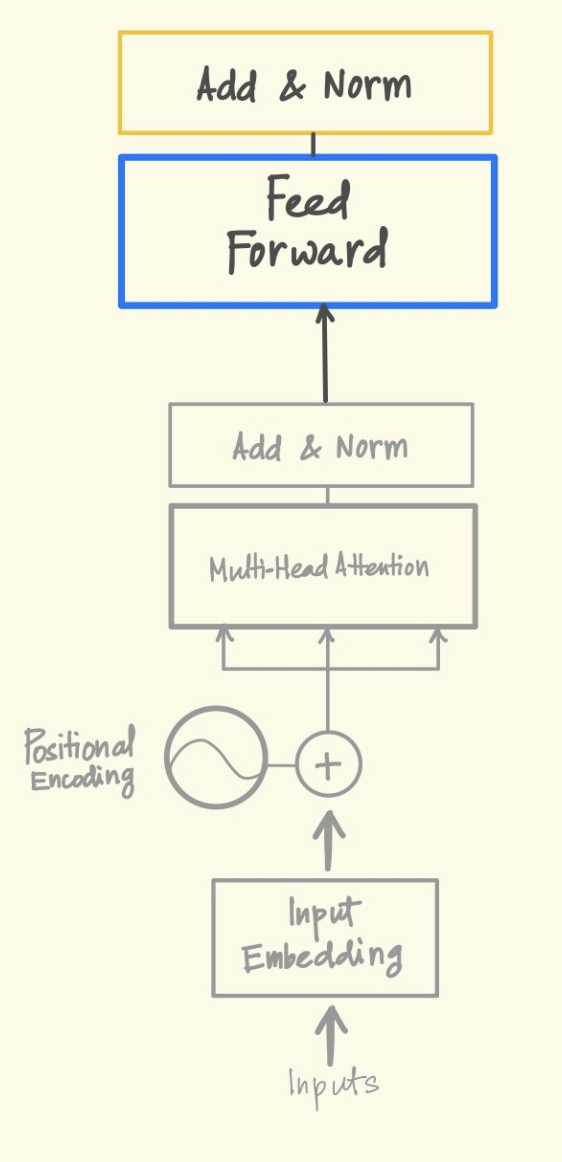

In [23]:
class FeedForwardBlock(nn.Module): #initialize the feedforward part of transformer
  def __init__(self,d_model:int,d_ff:int,dropout:float) -> None: # constructor with model dimension, feed-forward dimension, and dropout rate.
    super().__init__()
    self.linear_1 = nn.Linear(d_model,d_ff) # linear transformation from d_model to d_ff
    self.dropout = nn.Dropout(dropout) # dropout layer for regularization
    self.linear_2 = nn.Linear(d_ff,d_model) # second linear transformation back from d_ff to d_model

  def forward(self,x):
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x)))) # applies first linear transformation, ReLU activation, dropout and second linear transformation

### residual connection class
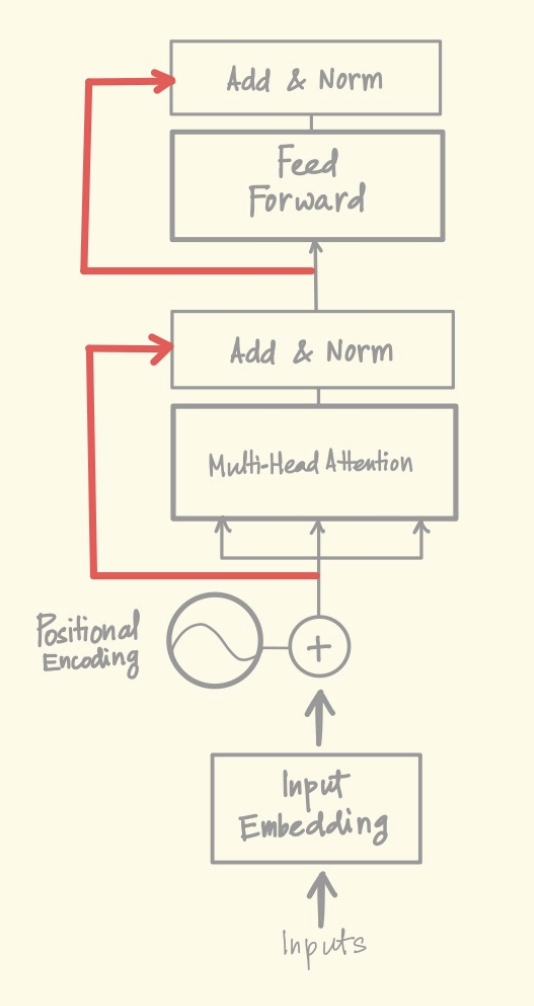

In [24]:
class ResidualConnection(nn.Module):
  def __init__(self,features: int,dropout:float) -> None:# constructor with feature count and dropout rate
    super().__init__()
    self.dropout = nn.Dropout(dropout) # dropout layer
    self.norm = LayerNormalization(features) #layer normalization

  def forward(self,x,sublayer):
    return x + self.dropout(sublayer(self.norm(x))) # applies layer norm, sub layer, dropout and residual connection

### Encoder block class
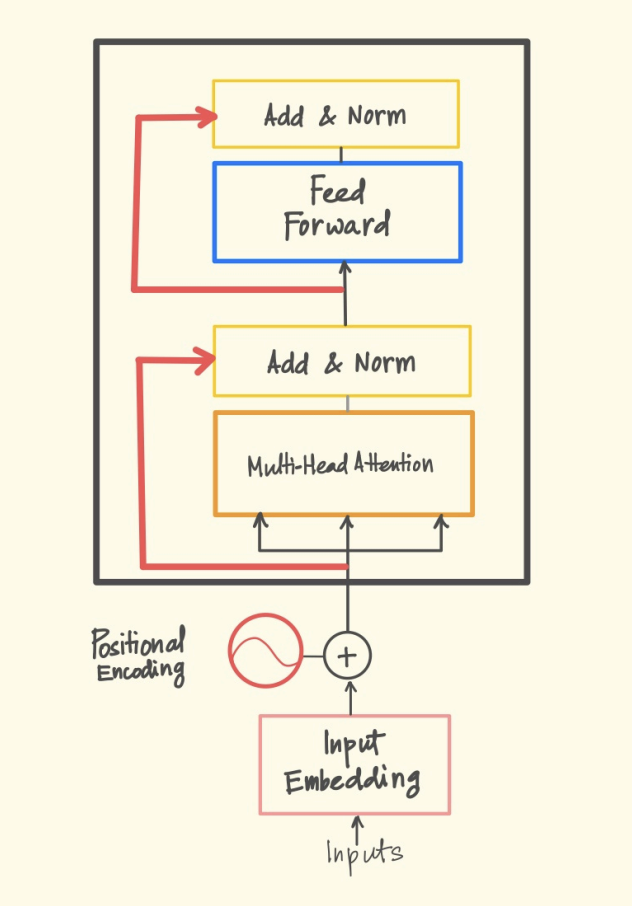

In [25]:
class EncoderBlock(nn.Module):
  def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

  def forward(self,x,src_mask):
    x = self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x,src_mask)) # applies self attention with residual connection
    x = self.residual_connections[1](x, self.feed_forward_block) # applies feedforward with residual connnection
    return x

#### encoder class

In [26]:
class Encoder(nn.Module):
  def __init__(self, features: int, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers # encoder blocks
    self.norm = LayerNormalization(features) #creates final normalization layer

  def forward(self,x,mask):
    for layer in self.layers:
      x = layer(x, mask) # pass the input through each encoder block
    return self.norm(x) #applies final normalization

### decoder block class

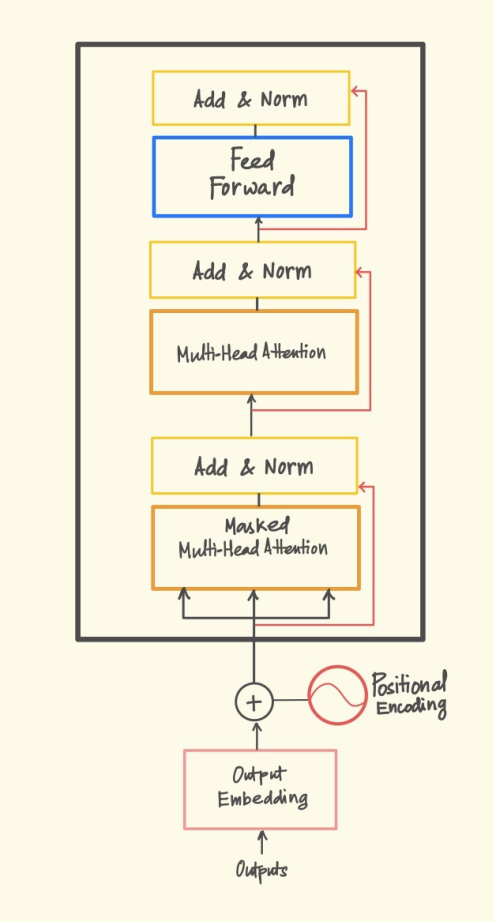


In [27]:
class DecoderBlock(nn.Module):
  def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)]) # create three residual connections

  def forward(self,x,encoder_output,src_mask,tgt_mask):
    x = self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x,tgt_mask)) # apply masked self-attention with residual connection
    x = self.residual_connections[1](x,lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask)) # apply cross attention with encoder output and residual connection
    x = self.residual_connections[2](x, self.feed_forward_block) # apply feedforward with residual connection
    return x

#### decoder class

In [28]:
class Decoder(nn.Module):
  def __init__(self,features: int, layers: nn.ModuleList) -> None:
    super().__init__()
    self.layers = layers # store decoder blocks
    self.norm = LayerNormalization(features) #creates final normalization layer

  def forward(self, x, encoder_output,src_mask,tgt_mask):
    for layer in self.layers:
      x = layer(x,encoder_output,src_mask,tgt_mask) # process the input through each decoder block
    return self.norm(x) # apply final normalization

### Projection layer class

In [29]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model, vocab_size) -> None: # constructor with model dimension and vocab size
    super().__init__()
    self.proj = nn.Linear(d_model,vocab_size) #creates linear projection layer

  def forward(self,x):
    return self.proj(x) #applies projection to vocabulary space

### Transformer class

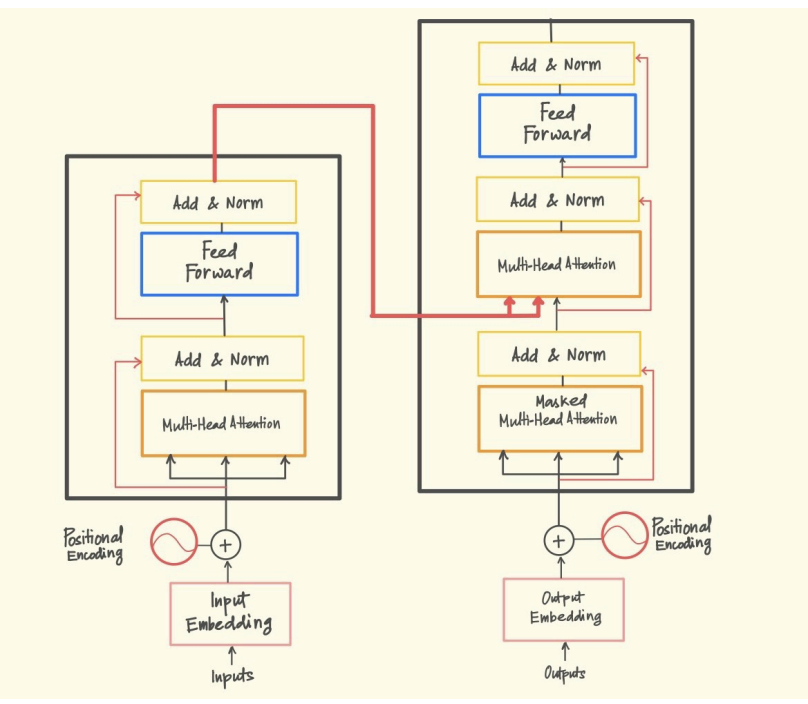

In [30]:
class Transformer(nn.Module):
  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer # store components as attributes

  def encode(self, src, src_mask): # method to encode source sequence
    src = self.src_embed(src) # embeds source tokens
    src = self.src_pos(src) # adds positional encoding
    return self.encoder(src, src_mask) # processes through encoder

  def decode(self, encoder_output: torch.Tensor,src_mask: torch.Tensor,tgt: torch.Tensor, tgt_mask: torch.Tensor): # method to decode target sequence
    tgt = self.tgt_embed(tgt) # embeds target tokens
    tgt = self.tgt_pos(tgt) # adds positional encoding
    return self.decoder(tgt,encoder_output, src_mask, tgt_mask) # processes through decoder

  # projects decoder output to vocabulary
  def project(self,x):
    return self.projection_layer(x) # applies projection layer

### Transformer builder function

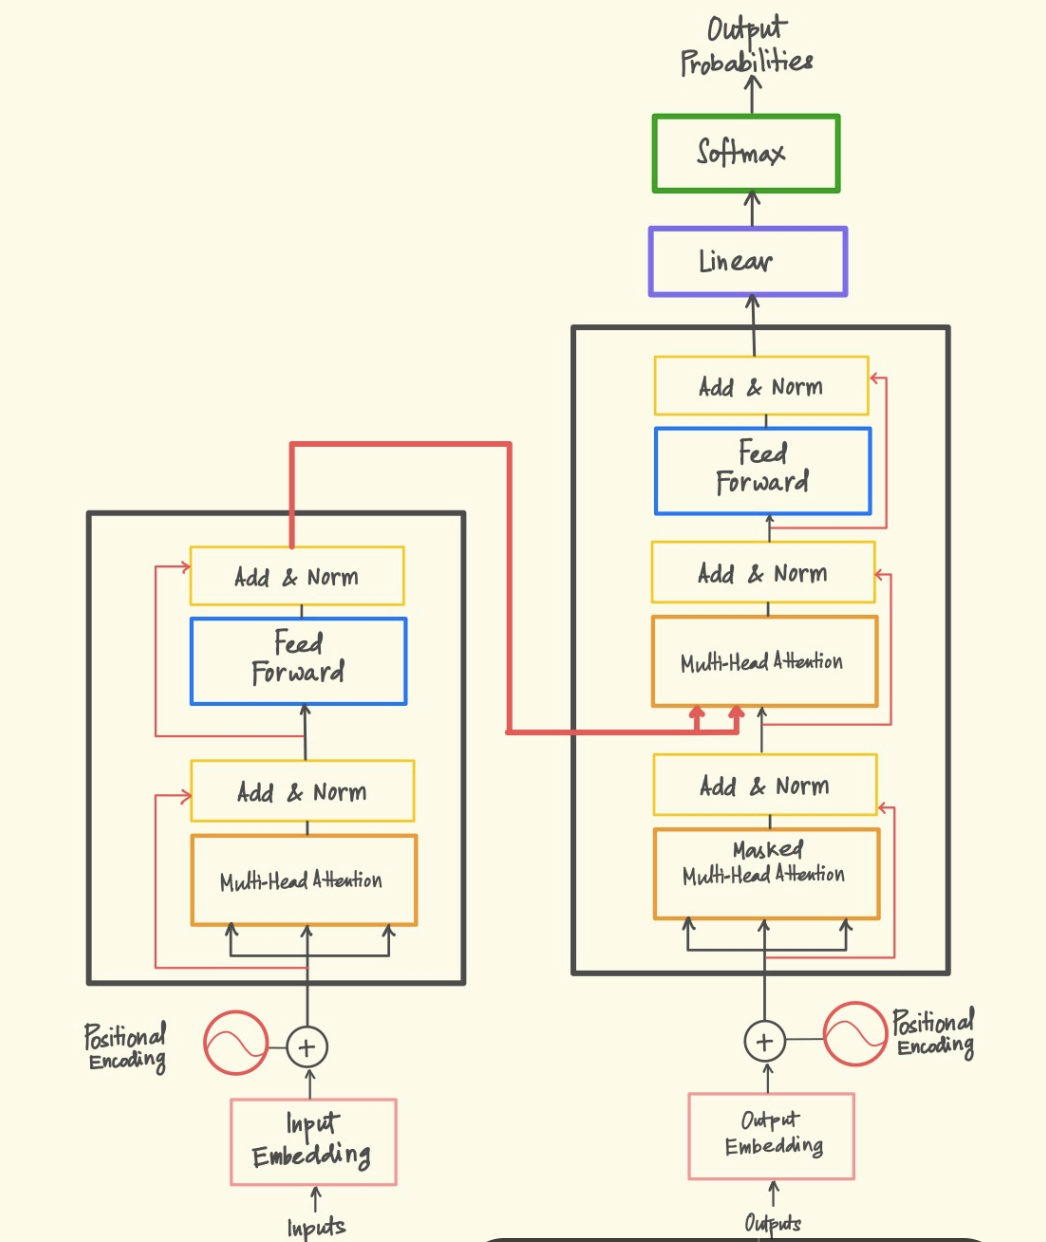

## Summary

It covers the following key components and their implementations:
- Input Embeddings Class: Converts input tokens into vectors.
- Positional Encoding Class: Adds positional information to embeddings using sine and cosine functions.
- Multi-Head Attention Block Class: Implements the core multi-head attention mechanism, including scaled dot-product attention.
- Layer Normalization Class: Stabilizes network activations by normalizing features.
- Feed Forward Block Class: Implements the feed-forward network with two linear transformations and ReLU activation.
- Residual Connection Class: Incorporates residual connections with layer normalization and dropout.
- Encoder Block Class: Combines self-attention and feed-forward networks with residual connections to form a single encoder layer.
- Encoder Class: Builds the full encoder by stacking multiple encoder blocks.
- Decoder Block Class: Implements a single decoder layer with masked self-attention, cross-attention, and a feed-forward network, all with residual connections.
- Decoder Class: Constructs the complete decoder by stacking multiple decoder blocks.
- Projection Layer Class: Projects the decoder output to the vocabulary size.
- Transformer Class: The main model that integrates all the encoder, decoder, embedding, and positional encoding components.
- Transformer Builder Function: A function to construct a complete Transformer model with default hyperparameters, including initialization of parameters using Xavier uniform initialization.

The document details the `__init__` and `forward` methods for each class, explaining the purpose of each line of code and the mathematical operations involved. It also includes diagrams illustrating the flow of data through different parts of the Transformer.

In [17]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048):
  # Create input embeddings layers
  src_embed = InputEmbeddings(d_model, src_vocab_size)
  tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

  # Create positional encoding layers
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  # Create encoder blocks
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
    encoder_blocks.append(encoder_block) # creates N encoder blocks with attention and feed-forward components

  # Create decoder blocks
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
    decoder_blocks.append(decoder_block) # creates N decoder blocks with self-attention, cross-attention, and feed-forward components

  # create encoder and decoder with respective blocks
  encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
  decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

  # create projection layer
  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  # create a complete transformer
  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

  # initialize parameters using Xavier uniform initialization
  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer

In [31]:
src_vocab_size = 10000 #  source vocabulary size
tgt_vocab_size = 10000 #  target vocabulary size
src_seq_len = 100     #  source sequence length
tgt_seq_len = 100     #  target sequence length

transformer_model = build_transformer(src_vocab_size, tgt_vocab_size, src_seq_len, tgt_seq_len)

# use the transformer_model for encoding and decoding
print(transformer_model)

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=512, out_features=512, bias=False)
          (w_k): Linear(in_features=512, out_features=512, bias=False)
          (w_v): Linear(in_features=512, out_features=512, bias=False)
          (w_o): Linear(in_features=512, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dropout(p=0.1, inplace=False)
            (norm): LayerNormalization()
          )
        )
      )
    )
    (norm): LayerNormalization